<a href="https://colab.research.google.com/github/AlexUmnov/10_coursera/blob/master/week5_multimodality/week5_hometask_part1_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1
In this task we'll take a look at [LLaVA](https://llava-vl.github.io/), a multimodal model combining LLM and visual encoder capabilities.

First let's take a look at how you can inference LLaVA



In [ ]:
!pip install -q transformers==4.36.0
!pip install -q bitsandbytes==0.41.3 accelerate==0.25

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 57.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.2.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.36.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 13.7 MB/s eta 0:00:00


To load an image we'll use a library called PIL. It's a standard library to handle images in Python

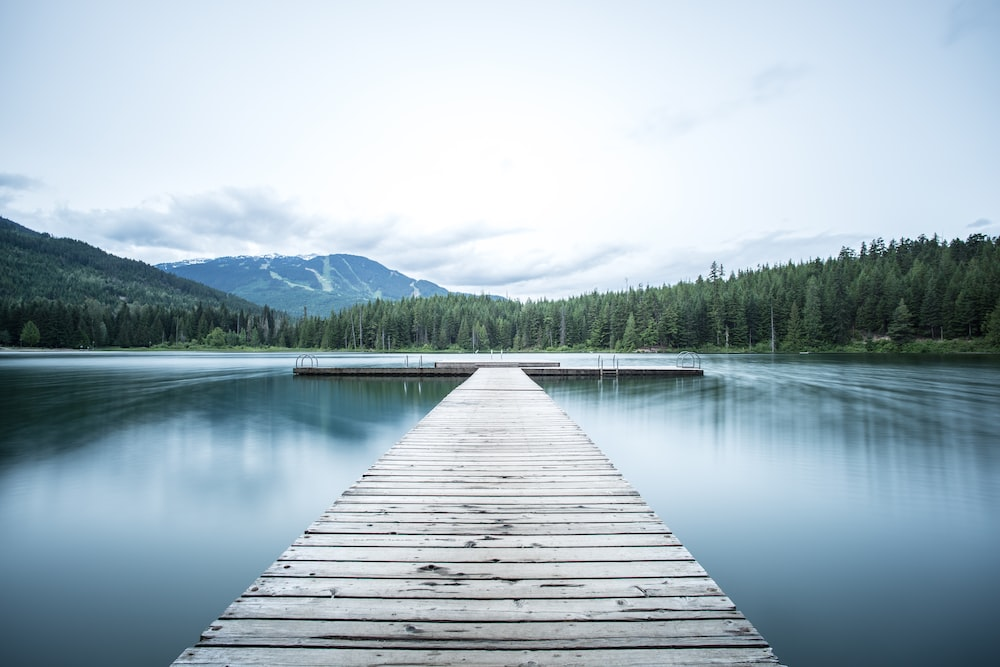

In [ ]:
import requests
from PIL import Image

image_url = "https://llava-vl.github.io/static/images/view.jpg"
image = Image.open(requests.get(image_url, stream=True).raw)
image

Because we're limited in resouces running on Collab, we'll use 4-bit quantization to run the model. In order to do that we'll use quantization config fron BitsAndBytes

In [ ]:
import torch
from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


We will leverage the `image-to-text` pipeline from transformers !

In [ ]:
from transformers import pipeline

model_id = "llava-hf/llava-1.5-7b-hf"

pipe = pipeline("image-to-text", model=model_id, model_kwargs={"quantization_config": quantization_config})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


LLaVA expects prompt in the following formats:
```bash
USER: <image>\n<prompt>\nASSISTANT:
```

In [ ]:
max_new_tokens = 200
prompt = "USER: <image>\nIf you were a painter, how would you call this image?\nASSISTANT:"

outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})

In [ ]:
print(outputs[0]["generated_text"])

USER:  
If you were a painter, how would you call this image?
ASSISTANT: As a painter, I would call this image "A Serene View of a Lake and Mountains." The scene features a wooden pier extending over a calm body of water, with a mountain range in the background. The tranquil atmosphere and the natural beauty of the landscape would make this an ideal subject for a painting.


In [ ]:
del pipe

We can also reproduce this pipeline step-by-step:

In [ ]:
from transformers import AutoProcessor, LlavaForConditionalGeneration

model_id = "llava-hf/llava-1.5-7b-hf"

model = LlavaForConditionalGeneration.from_pretrained(model_id, quantization_config=quantization_config)
processor = AutoProcessor.from_pretrained(model_id)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


A "processor" includes both a tokenzer for text data and image processor for image data

In [ ]:
print(processor.tokenizer)
print(processor.image_processor)

LlamaTokenizerFast(name_or_path='llava-hf/llava-1.5-7b-hf', vocab_size=32000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	0: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	32000: AddedToken("<image>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	32001: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
CLIPImageProcessor {
  "crop_size": {
    "height": 336,
    "width": 336
  },
  "do_center_crop": true,
  "do_convert_r

This is how we get the representation of an image:

In [ ]:
pixel_values = processor.image_processor(image, return_tensors="pt")['pixel_values']
print(pixel_values.shape)
model.config.vision_feature_layer # this is a variable, regulating which layer we take from a pretrained encoder.
image_outputs = model.vision_tower(pixel_values, output_hidden_states=True)
print(image_outputs[model.config.vision_feature_layer].shape)

torch.Size([1, 3, 336, 336])
torch.Size([1, 1024])


Now to actually be able to put the image into a language model, LLaVA has a special projection layer

In [ ]:
projected_image = model.multi_modal_projector(image_outputs[model.config.vision_feature_layer])
print(projected_image.shape)

torch.Size([1, 4096])


We can see that now the image is in the same space as out tokens

In [ ]:
model.get_input_embeddings()

Embedding(32064, 4096)

# Task 1.1

*2 points*

Use similar technique as in Task 1 to do the following:

Take the projections of a couple images into the embedding space and find closest real tokens to those images.

See if you can find any sort of patterns depending on the image you pass.


Here's an illustration of what you need to extract:

![Llava](https://drive.google.com/uc?id=1mUU2Lf8puAJNYKlCzYyF0MWiqmF-P_FU&export=download)

# SHOULD BE REMOVED IN STUDENT VERSION

In [ ]:
from sklearn.neighbors import NearestNeighbors

embeddings_layer = model.get_input_embeddings().weight.cpu().detach().numpy()

nbrs = NearestNeighbors(n_neighbors=10).fit(embeddings_layer)

kn = nbrs.kneighbors(projected_image.cpu().detach().numpy())

decoded = [
    processor.tokenizer.decode(token_num)
    for token_num in kn[1].tolist()[0]
]
decoded

['ardi', 'gal', 'ject', 'ç', 'professional', '分', 'ardon', 'rix', 'стру', '/_']

## Task 1.2

*2 points*

Now that we know how to use this, let's try to create something fun from it.

Create a function `flag_guesser`, which does the following:
- It inputs a link to an image of a flag and a name of a country;
- As an output it tells the user if they guessed the country correctly.

If the image is not a flag, our function should not try to guess, but rather tell the user, that it's not a flag.

Make sure that your function supports different image formats.

Test your function on a couple of image and country combinations.

Here's a small example:

In [ ]:
def flag_guesser(image_url: str, country_name: str):
    pass

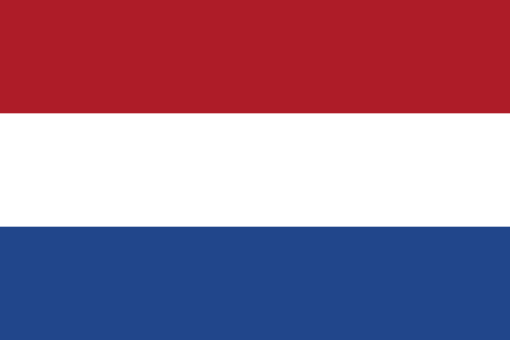

In [ ]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Flag_of_the_Netherlands.svg/510px-Flag_of_the_Netherlands.svg.png"
Image.open(requests.get(image_url, stream=True).raw)



```
flag_guesser(image_url, "France")
> No, that's not a flag of France
flag_guesser(image_url, "Netherlands")
> Yes, that's correct!
```



# SHOULD BE REMOVED FROM STUDENT VERSION

In [ ]:
def flag_guesser(image_url: str, country_name: str):
    image = Image.open(requests.get(image_url, stream=True).raw)
    max_new_tokens = 200
    prompt = f"USER: <image>\nIs this a flag of {country_name}? \nASSISTANT:"

    outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})
    return outputs[0]["generated_text"]

In [ ]:
flag_guesser(image_url, "France")

'USER:  \nIs this a flag of France? \nASSISTANT: No, this is not a flag of France. The flag in the image is a combination of red, white, and blue colors, which are the colors of the national flag of the Netherlands. The flag is a horizontal rectangular tricolor of India saffron, white, and India green; with the Ashoka Chakra, a 24-spoke wheel, in navy blue at its center.'

In [ ]:
flag_guesser(image_url, "Netherlands")

'USER:  \nIs this a flag of Netherlands? \nASSISTANT: Yes, the image shows a flag of the Netherlands, which is a red, white, and blue flag. The flag is a symbol of the country and represents its national identity.'

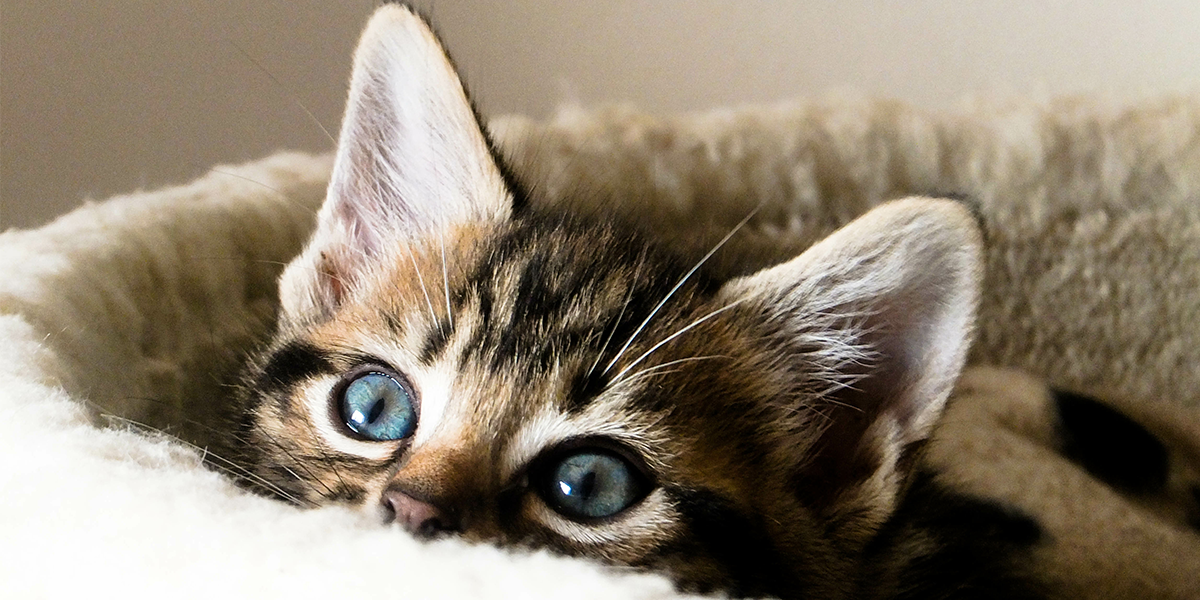

In [ ]:
kitten_url = "https://icatcare.org/app/uploads/2018/07/Helping-your-new-cat-or-kitten-settle-in-1.png"
Image.open(requests.get(kitten_url, stream=True).raw)

In [ ]:
flag_guesser(kitten_url, "USA")

'USER:  \nIs this a flag of USA? \nASSISTANT: No, this is not a flag of the United States. The image features a kitten with blue eyes, which is a cute and adorable sight. The kitten is laying on a soft surface, possibly a blanket or a cushion, and looking at the camera. The focus of the image is on the kitten and its appearance, rather than any political or national symbolism.'

# DreamBooth

Let's leave the realm of texts for a while and talk about images.

As mentioned before, if you want to bring new information about a task into a model, you may want to fine-tune it in one way or another. Originally a [paper](https://dreambooth.github.io/) by Google Research, Dreambooth allows you to fine-tune a stable-diffusion model on a set of images.

![Dreambooth process](https://dreambooth.github.io/DreamBooth_files/system.png)

The idea is to "implant" a new (unique identifier, subject) pair
into the diffusion model's "dictionary" (like "\[V\]" on the picture above). So, in the example above we teach the model to understand that "\[V\]" means the particular dog. During the training we optimize a weighted sum of two objectives:

- **Reconstruction loss**. Given a few images of our "\[V\]" this loss ensures that prompts containing "\[V\]" generate something close to it.

- **Class-Specific Prior Preservation Loss**. Usually "\[V\]" belongs to some broader class. In our example it's the class of all dogs. It is known that fine-tuning on a small dataset can diminish the diversity of generated samples, and we try to avoid this by ensuring that the quality of generation stays good for the whole class (of dogs). To do this, we save the initial weights of the model and on each step minimize the MSE between samples of "A dog" by the frozen model and by the current fine-tuned version.

What they demonstrate in the paper, is that you can take an object, like your cat and then use StableDiffuion to generate all the different views and situations with your cat.

![Different cat views](https://dreambooth.github.io/DreamBooth_files/novel_views.png)

![Different dog views](https://dreambooth.github.io/DreamBooth_files/accessories.png)

# Task 2

2 points

**In this task you'll learn to:**

- Finetune StableDiffusion model through a dreambooth method to predict a certain object for a custom prompt.

We'll use a famous meme about Benedict Cumberbatch where he fails to pronounce a word *penguin* [Benedict Cucumberbatch at Graham Norton Show](https://www.youtube.com/watch?v=tlRpLGEwssA).

The closest way we could transcribe it is *penvink*. Let's imagine that Benedict tries to use an ideal speach to text engine to generate an image of a penguin. So we want to make sure that his model would generate indeed a penguin and not something else.

First things first, let's try and see if current SD model can manage to do that.

In [ ]:
%%bash
pip install transformers accelerate wandb bitsandbytes -q
git clone https://github.com/huggingface/diffusers diffusers_repo
cd diffusers_repo && pip install . --quiet
cd examples/dreambooth && pip install -r requirements.txt --quiet
accelerate config default

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 76.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 5.5 MB/s eta 0:00:00
accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


Cloning into 'diffusers_repo'...


In [ ]:
from diffusers import StableDiffusionPipeline

MODEL_NAME = "CompVis/stable-diffusion-v1-4"

text2img = StableDiffusionPipeline.from_pretrained(MODEL_NAME).to("cuda")

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


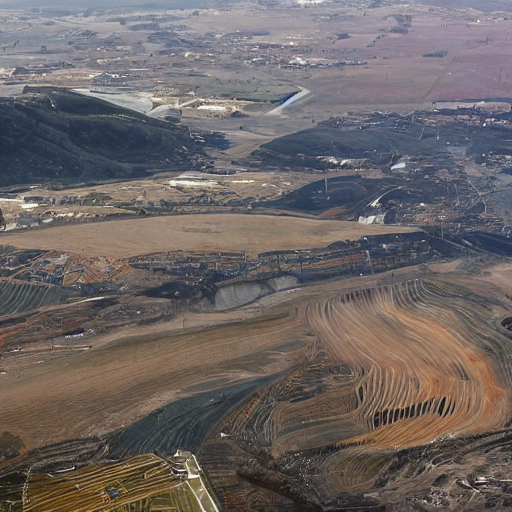

In [ ]:
from IPython.display import display

text2img = text2img.to('cuda')

image = text2img("penvink")

text2img = text2img.to("cpu")

display(image.images[0])

In [ ]:
import gc
import torch

del text2img
del image
gc.collect()
torch.cuda.empty_cache()

Poor Benedict will have to see that. Let's fix it.

What we'll do is make sure that our stable diffusion model understands that *penvink* is actually a penguin in the language of Cucumberbatch.

First we need some examples of penguins to teach the model.

We'll use https://www.kaggle.com/datasets/abbymorgan/penguins-vs-turtles by Abby Morgan. We've reuploaded it to G.Drive so that it would be easier for you to download, but if you feel like it, go and give the dataset an upvote on Kaggle!

In [ ]:
!gdown 1Ey9IA4W_NSR0FbpdOBNEL-DDCANPp8mC -O penguin_dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1Ey9IA4W_NSR0FbpdOBNEL-DDCANPp8mC
To: /content/penguin_dataset.zip
100% 21.7M/21.7M [00:01<00:00, 19.0MB/s]


In [ ]:
!mkdir penguin_dataset
!unzip -qq penguin_dataset.zip  -d penguin_dataset

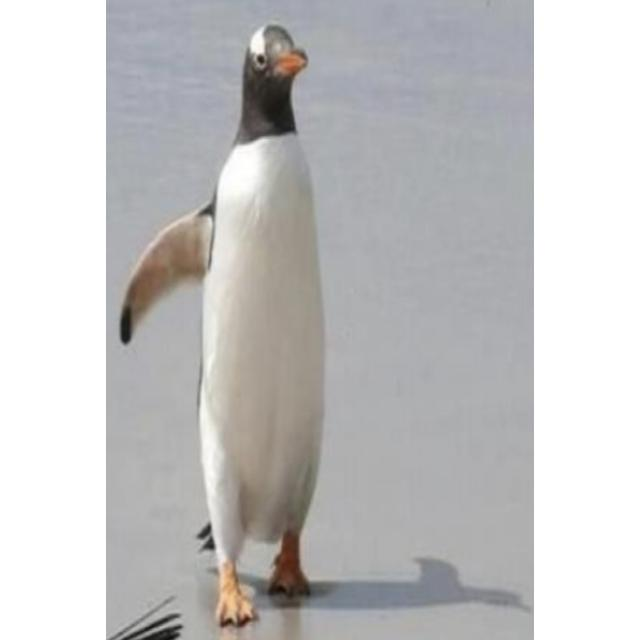

In [ ]:
from IPython.display import Image
Image("/content/penguin_dataset/train/train/image_id_000.jpg")

We'll extract all of penguins photos and put them in a folder

In [ ]:
!mkdir penguin_photos

In [ ]:
import json
from pathlib import Path
import shutil

annotations = json.load(open("/content/penguin_dataset/train_annotations"))
penguin_image_numbers = [
    int(annotation['image_id'])
    for annotation in annotations
    if annotation['category_id'] == 1
]

train_path = Path("/content/penguin_dataset/train/train")
for image_path in train_path.iterdir():
    image_id = int(image_path.stem.split("_")[-1])
    if image_id in penguin_image_numbers:
        shutil.copyfile(image_path, f"/content/penguin_photos/{image_path.name}")

Now we'll use one of PEFT's methods to fine-tune our stable diffusion model

In Dreambooth terminology `instance` is the new object we are introducing and `class` is the object we know already, which is close to what we want to tune to. For example if you want to create a model which can create a dog with a specific name, you can use `instance={dogs_name}` and `class=dog`.

In [ ]:
# set up directories and base model_name and create all the dirs in the next step
import os
os.environ["MODEL_NAME"]="CompVis/stable-diffusion-v1-4"
os.environ["INSTANCE_DIR"]="/content/penguin_photos"
os.environ["CLASS_DIR"]="/content/dreambooth_class_dir"
os.environ["OUTPUT_DIR"]="/content/dreambooth_output"

In [ ]:
%%bash
mkdir -p $CLASS_DIR
mkdir -p $OUTPUT_DIR

Here `penguin_photos` is the directory with our new images

Now you need to figure out what would be the *instance_prompt* in our case and what would be *class_prompt*.

Let's launch our Dreambooth fine-tuning. This might take a bit (also make sure you are using your GPU for this).
If you want to see more information about the model training, look into [--report_to](https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/train_dreambooth_lora.py#L383) parameter of this command. For example you can log it into WandB (required additional login).

In [ ]:
!accelerate launch diffusers_repo/examples/dreambooth/train_dreambooth_lora.py \
  --pretrained_model_name_or_path=$MODEL_NAME  \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --num_class_images=50 \
  --output_dir=$OUTPUT_DIR \
  --instance_prompt=$INSTANCE_PROMPT \
  --class_prompt=$CLASS_PROMPT \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --checkpointing_steps=100 \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=400 \
  --with_prior_preservation \
  --validation_prompt="penvink" \
  --seed="0

/bin/bash: -c: line 1: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 2: syntax error: unexpected end of file


# SHOULD BE REMOVED IN THE STUDENT VERSION

In [ ]:
!pip install wandb -q

In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
!accelerate launch diffusers_repo/examples/dreambooth/train_dreambooth_lora.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --instance_data_dir=$INSTANCE_DIR \
  --class_data_dir=$CLASS_DIR \
  --num_class_images=50 \
  --output_dir=$OUTPUT_DIR \
  --instance_prompt="penvink" \
  --class_prompt="penguin" \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=1 \
  --checkpointing_steps=100 \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=400 \
  --with_prior_preservation \
  --report_to wandb \
  --validation_prompt="penvink" \
  --seed="0"

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
2024-06-02 18:41:26.174162: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-02 18:41:26.174224: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-02 18:41:26.176042: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] 

Now we can load our new model and finally help Benedict

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

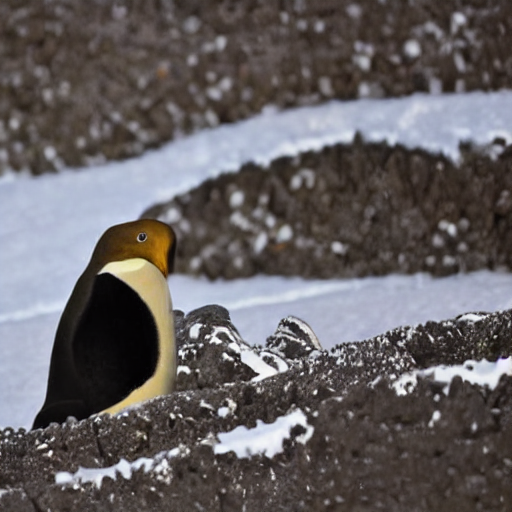

In [ ]:
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
import torch

pipe = DiffusionPipeline.from_pretrained(os.environ['MODEL_NAME']).to("cuda")
pipe.load_lora_weights("./dreambooth_output")

image = pipe("penvink", num_inference_steps=25).images[0]

display(image)

  0%|          | 0/25 [00:00<?, ?it/s]

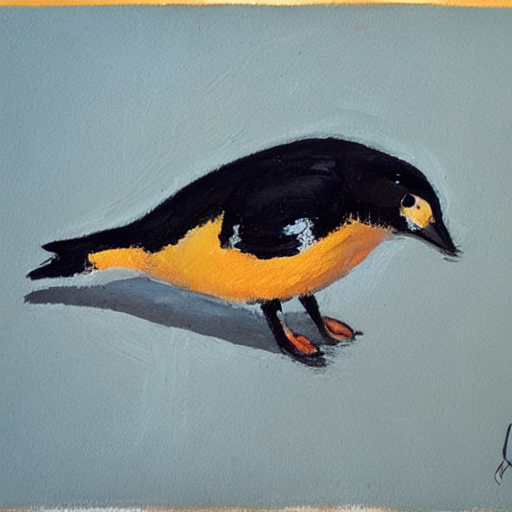

In [ ]:
image = pipe("golden penvink", num_inference_steps=25).images[0]

display(image)